In [140]:
#Importing libraries 
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [141]:
CARS = pd.read_csv(r"usedcars.csv")

In [142]:
CARS.head()

,title,price_in_aed,kilometers,body_condition,mechanical_condition,seller_type,body_type,no_of_cylinders,transmission_type,regional_specs,horsepower,fuel_type,steering_side,year,color,emirate,motors_trim,company,model,date_posted
0,MITSUBISHI PAJERO 3.5L / 2013,26000,167390,Perfect inside and out,Perfect inside and out,Dealer,SUV,6,Automatic Transmission,GCC Specs,Unknown,Gasoline,Left Hand Side,2013.0,Silver,Dubai,GLS,mitsubishi,pajero,13/05/2022
1,chevrolet silverado,110000,39000,Perfect inside and out,Perfect inside and out,Dealer,SUV,8,Automatic Transmission,North American Specs,400to500 HP,Gasoline,Left Hand Side,2018.0,White,Sharjah,1500 High Country,chevrolet,silverado,14/01/2022
2,MERCEDES-BENZ E300 - 2014 - GCC SPEC - FULL OP...,78000,200000,Perfect inside and out,Perfect inside and out,Dealer,Sedan,6,Automatic Transmission,GCC Specs,400to500 HP,Gasoline,Left Hand Side,2014.0,Blue,Sharjah,E 300,mercedes-benz,e-class,5/5/22
3,WARRANTY UNTIL APR 2023 || Ferrari 488 Spider ...,899000,27000,Perfect inside and out,Perfect inside and out,Dealer,Hard Top Convertible,8,Automatic Transmission,GCC Specs,600to700 HP,Gasoline,Left Hand Side,2018.0,Red,Dubai,Standard,ferrari,488-spider,30/04/2022
4,USED RENAULT DOKKER 2020,33000,69000,Perfect inside and out,Perfect inside and out,Owner,Wagon,4,Manual Transmission,GCC Specs,Less than 150 HP,Gasoline,Left Hand Side,2020.0,White,Dubai,Standard,renault,dokker,13/05/2022


In [143]:
CARS.shape

(9970, 20)

In [144]:
CARS = CARS.drop(columns="title")

Changing the AED (currency of the United Arab Emirates) to USD 

In [146]:
CARS = CARS.rename(columns={'price_in_aed': 'price'})
CARS['price'] = CARS['price'] * 0.27

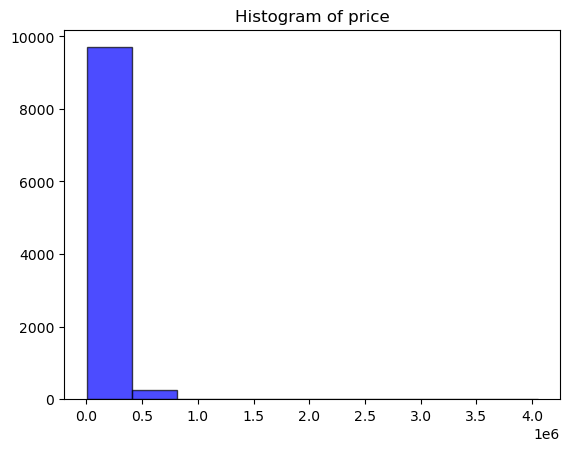

In [147]:
plt.hist(CARS['price'], bins=10, alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of price')
plt.show()

In [148]:
CARS['log10price'] = np.log10(CARS['price'])
CARS = CARS.drop(columns='price')

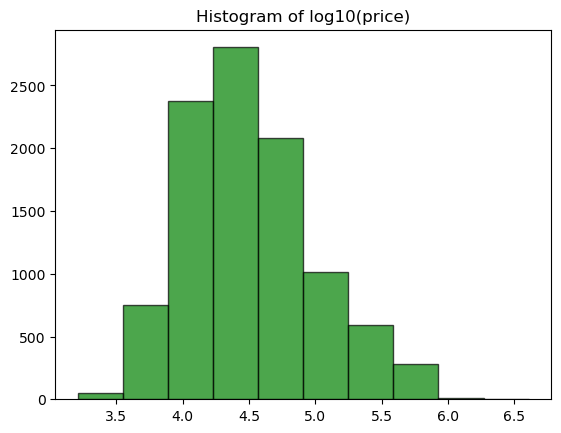

In [149]:
# The histogram of the log of price as the price is highly skewed 
plt.hist(CARS['log10price'], bins=10, alpha=0.7, color='green', edgecolor='black')
plt.title('Histogram of log10(price)')
plt.show()


**kilometers** - There's *clearly* a typo of 115000000. I'm going to guess 
they added an extra two 0s, so let's replace that value with the guess.  
The distribution is *very* skewed, and many predictive models would prefer 
symmetric predictors (otherwise outliers can greatly influence the form of 
the model).  We can't just take the logarithm since there are 0s, but we can 
add one km to each, and then log them!  Let's do that, renaming the column to 
make it clear what we did, and then drop the original column.  @Kahoot3 - why 
add 1?


In [151]:
print(CARS.columns)

Index(['kilometers', 'body_condition', 'mechanical_condition', 'seller_type',
       'body_type', 'no_of_cylinders', 'transmission_type', 'regional_specs',
       'horsepower', 'fuel_type', 'steering_side', 'year', 'color', 'emirate',
       'motors_trim', 'company', 'model', 'date_posted', 'log10price'],
      dtype='object')


In [152]:
len(CARS.columns)

19

count    9.970000e+03
mean     9.894896e+04
std      1.154300e+06
min      0.000000e+00
25%      2.314350e+04
50%      7.600000e+04
75%      1.330828e+05
max      1.150000e+08
Name: kilometers, dtype: float64


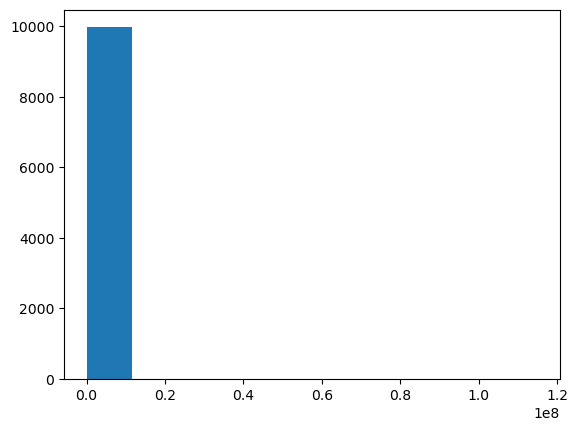

In [153]:
plt.hist(CARS['kilometers'])
print(CARS['kilometers'].describe())
CARS.loc[CARS['kilometers'] > 1e7, 
         'kilometers'] = CARS.loc[CARS['kilometers'] > 1e7,
                                  'kilometers'] / 100


From the above histogram we can see that "kilometers" is highly skewed, so we need to symmetrize that using log10 transformation

In [155]:
# converting the kilometers to log10 of kilometers as the it highly skewed
CARS['log10kilometers'] = np.log10(1 + CARS['kilometers'])  
CARS = CARS.drop(columns=['kilometers'])                       


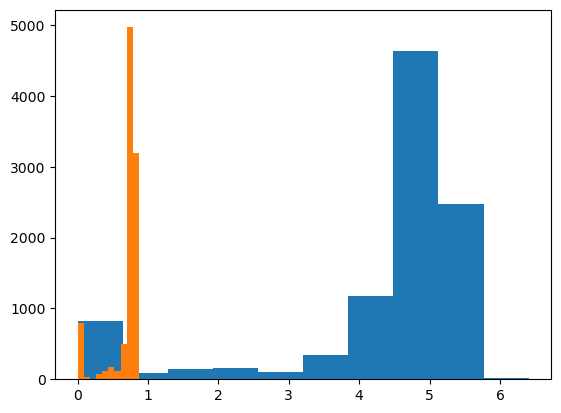

In [156]:
plt.hist(CARS['log10kilometers'])    
plt.hist(np.log10(1+CARS['log10kilometers'])) 
plt.show() 


**mechanical_condition**:   some of the levels are too rare to use in the model. 
Remember that we will be splitting the data into training and holdout, then in 
the training set using 5-fold cross validation to estimate generalization errors.
Assuming a 75% - 25% training/holdout split, that gives about 7500 cars in training. 
Split 5 ways, each "pseudo-training" set during 5-fold cross-validation would have
about 6000 cars in it, or about 60% of our full dataset.  I typically like to have 
at least 10 examples of a level in order to incorporate it into the model, so the 
minimum number of examples of each level in our full dataset should be at least
10/.6 = 17 or so.  

We'll need to combine the rarer levels!  Although combining the rare ones only gives 
12 instances in "Other", that's the best we can do unless went to go to a "Perfect" vs. 
"Not Perfect" condition split. 

In [159]:
print(CARS['mechanical_condition'].describe())

count                       9970
unique                         5
top       Perfect inside and out
freq                        9822
Name: mechanical_condition, dtype: object


In [160]:
min_threshold = 17
CARS['mechanical_condition'] = CARS['mechanical_condition'].apply(
    lambda x: x if (CARS['mechanical_condition'].value_counts()[x] >= min_threshold) else 'Other'
)
print(CARS['mechanical_condition'].value_counts())

mechanical_condition
Perfect inside and out     9822
Minor faults, all fixed     136
Other                        12
Name: count, dtype: int64


In [161]:
# **seller_type** and  **body_type**:  looks fine since all levels are well-represented
print(CARS['seller_type'].value_counts())

seller_type
Dealer                            6762
Owner                             2938
Dealership/Certified Pre-Owned     270
Name: count, dtype: int64


In [162]:
print(CARS['body_type'].value_counts())

body_type
SUV                     4566
Sedan                   2748
Coupe                    851
Pick Up Truck            428
Hatchback                344
Sports Car               260
Hard Top Convertible     162
Van                      162
Soft Top Convertible     142
Crossover                114
Other                    102
Wagon                     66
Utility Truck             25
Name: count, dtype: int64


In [163]:
# **no_of_cylinders**:  seems fine
print(CARS['no_of_cylinders'].value_counts())

no_of_cylinders
6     3325
4     3131
8     2986
12     366
3       56
10      53
5       53
Name: count, dtype: int64


In [164]:
print(CARS['no_of_cylinders'].describe())

count    9970.000000
mean        6.190271
std         1.969984
min         3.000000
25%         4.000000
50%         6.000000
75%         8.000000
max        12.000000
Name: no_of_cylinders, dtype: float64


In [165]:
# **transmission_type** and **regional_specs**:  seems fine - plenty of each level
print(CARS['transmission_type'].value_counts()) 

transmission_type
Automatic Transmission    9581
Manual Transmission        389
Name: count, dtype: int64


In [166]:
print(CARS['regional_specs'].value_counts())

regional_specs
GCC Specs               7601
North American Specs    1147
Other                    551
European Specs           422
Japanese Specs           249
Name: count, dtype: int64


**horsepower**:  Looks like it has been pre-cleaned and discretized
into categories for us (makes sense since it is unknown for 814 
cars).  There's enough representation in levels to proceed.

In [168]:
print(CARS['horsepower'].value_counts())

horsepower
200to300 HP         2432
300to400 HP         2208
400to500 HP         1279
150to200 HP         1222
500to600 HP         1027
Unknown              814
Less than 150 HP     394
600to700 HP          391
700to800 HP          153
800to900 HP           30
900+ HP               20
Name: count, dtype: int64


In [169]:
# **fuel_type**: Looks fine, plenty of each level
print(CARS['fuel_type'].value_counts())

fuel_type
Gasoline    9695
Diesel       167
Electric      85
Hybrid        23
Name: count, dtype: int64


**steering_side**:  Challenging predictor. There's only 5 examples of Right Hand Side steering. Can we really flesh out the relationship between price and these 5 examples (only 4 of which will likely end up in the  training dataset).  My guess is no, so let's throw it out.

In [171]:
print(CARS['steering_side'].value_counts())
CARS = CARS.drop(columns=['steering_side'])   
len(CARS.columns)


steering_side
Left Hand Side     9965
Right Hand Side       5
Name: count, dtype: int64


18

**year**  There's a LOT of NAs.  If we want to use this column as a predictor (and I think we should...older cars typically sell for less, but some of the older cars buck that tend), we need to either come up with a way to "guess" the year (not realistic, but we could replace it with the average year in the data) or we can discretize the year column and create a category for "Unknown". From the scatterplot, it almost looks like prices decrease going back in time until about 2003 or so...then for some reason older cars tend to sell for even more. However, there's not enough representation of early years to give them their own category. 

Let's try this two ways
1)  Replace NAs with the average year
2)  Discretize


In [173]:
# And let's remove the original year column.
CARS["year"].describe()

count    9000.000000
mean     2015.626444
std         4.735991
min      1953.000000
25%      2014.000000
50%      2016.000000
75%      2019.000000
max      2021.000000
Name: year, dtype: float64

In [174]:
CARS["year"].value_counts()

year
2016.0    973
2015.0    909
2019.0    903
2021.0    881
2018.0    859
2017.0    791
2020.0    781
2014.0    752
2013.0    603
2012.0    385
2011.0    252
2009.0    185
2008.0    178
2010.0    170
2007.0    103
2006.0     74
2005.0     54
2004.0     29
2001.0     18
2003.0     15
2002.0     11
2000.0     10
1999.0      9
1989.0      6
1998.0      6
1990.0      3
1983.0      3
1997.0      3
1991.0      3
1971.0      2
1980.0      2
1964.0      2
1965.0      2
1992.0      2
1994.0      2
1973.0      2
1987.0      2
1976.0      1
1996.0      1
1984.0      1
1977.0      1
1972.0      1
1979.0      1
1954.0      1
1953.0      1
1995.0      1
1974.0      1
1969.0      1
1975.0      1
1982.0      1
1960.0      1
1970.0      1
Name: count, dtype: int64

In [175]:
# Handle missing values in 'year' by replacing them with the mean
CARS['car_year1'] = CARS['year'].fillna(CARS['year'].mean())
# Summary statistics of 'car_year1'
print(CARS['car_year1'].describe())


count    9970.000000
mean     2015.626444
std         4.499686
min      1953.000000
25%      2014.000000
50%      2016.000000
75%      2019.000000
max      2021.000000
Name: car_year1, dtype: float64


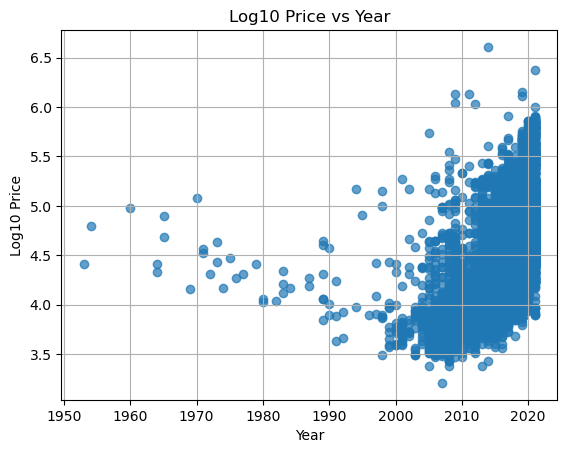

In [176]:
# Plot log10price ~ year
plt.scatter(CARS['year'], CARS['log10price'], alpha=0.7)
plt.title('Log10 Price vs Year')
plt.xlabel('Year')
plt.ylabel('Log10 Price')
plt.grid(True)
plt.show()

In [177]:
bins = [1950, 1989, 1999, 2002, 2004] + list(range(2005, 2022))
labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins) - 1)]

In [178]:
# Cut 'year' into bins and handle NaN values
CARS['car_year2'] = pd.cut(CARS['year'], bins=bins, include_lowest=True, labels=labels)
CARS['car_year2'] = CARS['car_year2'].cat.add_categories('Unknown').fillna('Unknown')


In [179]:

# Summary of 'car_year2' (counts for each category)
print(CARS['car_year2'].value_counts())


car_year2
2015-2016    973
Unknown      970
2014-2015    909
2018-2019    903
2020-2021    881
2017-2018    859
2016-2017    791
2019-2020    781
2013-2014    752
2012-2013    603
2011-2012    385
2010-2011    252
2008-2009    185
2007-2008    178
2009-2010    170
2006-2007    103
2005-2006     74
2004-2005     54
2002-2004     44
1999-2002     39
1950-1989     34
1989-1999     30
Name: count, dtype: int64


**color**:  There's too few Tan and Teal colors, and Purple is pretty rare too.  
Let's combine those.  A quick way to do that is to combine all levels that appear 
25 times or fewer into "Other".  Notice there is an "Other Color" category we could 
combine these into, but we won't here

In [181]:
CARS['color'].value_counts()

color
White          3333
Black          2096
Grey           1325
Silver          851
Blue            712
Red             600
Gold            257
Brown           237
Green           142
Orange           79
Other Color      79
Yellow           78
Beige            73
Burgundy         71
Purple           24
Teal              8
Tan               5
Name: count, dtype: int64

In [182]:
# Apply the lumping logic directly using `map` and `value_counts`
threshold = 25
# color_counts = CARS['color'].value_counts()
CARS['color'] = CARS['color'].map(lambda x: x if CARS['color'].value_counts()[x] >= threshold else 'Other')


In [183]:
CARS['color'].value_counts()

color
White          3333
Black          2096
Grey           1325
Silver          851
Blue            712
Red             600
Gold            257
Brown           237
Green           142
Other Color      79
Orange           79
Yellow           78
Beige            73
Burgundy         71
Other            37
Name: count, dtype: int64

**emirate**:  Weird, it looks like most appear twice in the data.  Looking at the levels, we see extra spaces have been inserted. 
Let's remove all spaces (which will automatically combine like levels).  There's no enough instances of Fujeirah and UmmAlQawain to
proceed, so let's combine (along with RasAlKhaimah).  Using a minimum threshold of 25 will do so nicely.  

In [185]:
CARS['emirate'].value_counts()

emirate
 Dubai             7978
 Sharjah            953
 Abu Dhabi          710
 Ajman              139
Abu Dhabi            53
 Al Ain              35
Sharjah              34
Dubai                21
 Ras Al Khaimah      17
Ajman                 7
 Umm Al Qawain        6
Al Ain                6
 Fujeirah             5
Ras Al Khaimah        3
Fujeirah              2
Umm Al Qawain         1
Name: count, dtype: int64

In [186]:
CARS['emirate'] = pd.Categorical(CARS['emirate'])

In [187]:
CARS['emirate'].cat.categories 

Index([' Abu Dhabi', ' Ajman', ' Al Ain', ' Dubai', ' Fujeirah',
       ' Ras Al Khaimah', ' Sharjah', ' Umm Al Qawain', 'Abu Dhabi', 'Ajman',
       'Al Ain', 'Dubai', 'Fujeirah', 'Ras Al Khaimah', 'Sharjah',
       'Umm Al Qawain'],
      dtype='object')

In [188]:
CARS['emirate'] = pd.Categorical(CARS['emirate'].str.replace(" ", "", regex=False))

In [189]:
CARS['emirate'].cat.categories 

Index(['AbuDhabi', 'Ajman', 'AlAin', 'Dubai', 'Fujeirah', 'RasAlKhaimah',
       'Sharjah', 'UmmAlQawain'],
      dtype='object')

In [190]:
CARS['emirate'].value_counts()

emirate
Dubai           7999
Sharjah          987
AbuDhabi         763
Ajman            146
AlAin             41
RasAlKhaimah      20
Fujeirah           7
UmmAlQawain        7
Name: count, dtype: int64

In [191]:
CARS['emirate'] = CARS['emirate'].map(lambda x: x if CARS['emirate'].value_counts()[x] >= 25 else 'Other')

In [192]:
CARS['emirate'].value_counts()

emirate
Dubai       7999
Sharjah      987
AbuDhabi     763
Ajman        146
AlAin         41
Other         34
Name: count, dtype: int64

**motors_trim:**  With 857 levels, this is a mess.  For linear regression, this is too many levels 
(including it in the model would require adding 856 indicator variables).  About the best we can do 
it look at the most frequent levels.  If it plays a really important role in the model, we can always 
go back and revisit. For now lets reduce it to the top 15 levels (Other being one of those).

In [194]:
print(CARS['motors_trim'].value_counts())

motors_trim
Other         2175
Standard       432
SE             232
S              227
G 63 AMG       197
              ... 
200              1
M40i             1
SLK 280          1
CL 63 AMG        1
2500HD LTZ       1
Name: count, Length: 856, dtype: int64


In [195]:
CARS['motors_trim'].describe()

count      9942
unique      856
top       Other
freq       2175
Name: motors_trim, dtype: object

In [196]:
 CARS['motors_trim'].isna().sum()

28

In [197]:
CARS['motors_trim'] = CARS['motors_trim'].fillna('Unknown')

In [198]:
CARS['motors_trim'] = CARS['motors_trim'].map(lambda x: x if CARS['motors_trim'].value_counts()[x] >= 15 else 'Other')

In [199]:
print(CARS['motors_trim'].value_counts())

motors_trim
Other             4637
Standard           432
SE                 232
S                  227
G 63 AMG           197
                  ... 
GT3                 15
TRX                 15
Prestige            15
320i                15
GLC 250 4MATIC      15
Name: count, Length: 118, dtype: int64


**company:**  Same sort of issue.   For now lets reduce it to the top 20 levels (Other being one of those).  
I'm choosing more categories here since the brand name (e.g. rolls-royce, ferrari, lexus) can play a huge role in price.

In [201]:
CARS['company'].value_counts()

company
mercedes-benz    1506
nissan            898
toyota            868
bmw               690
land-rover        577
                 ... 
jac                 1
levc                1
buick               1
foton               1
maxus               1
Name: count, Length: 73, dtype: int64

In [202]:
CARS['company'].describe()

count              9970
unique               73
top       mercedes-benz
freq               1506
Name: company, dtype: object

In [203]:
CARS['company'] = CARS['company'].map(lambda x: x if CARS['company'].value_counts()[x] >= 15 else 'Other')

In [204]:
CARS['company'].value_counts()

company
mercedes-benz    1506
nissan            898
toyota            868
bmw               690
land-rover        577
ford              551
porsche           390
audi              381
lexus             331
jeep              314
dodge             305
chevrolet         292
mitsubishi        287
volkswagen        222
hyundai           206
rolls-royce       180
infiniti          176
honda             158
bentley           144
ferrari           135
kia               129
cadillac          127
gmc               121
Other             117
lamborghini       108
jaguar             96
maserati           94
mazda              77
renault            74
mini               69
lincoln            59
peugeot            47
tesla              36
aston-martin       32
suzuki             30
maybach            29
mclaren            29
volvo              26
alfa-romeo         22
chrysler           20
fiat               17
Name: count, dtype: int64

**model:**  552 different models is too many.  Clearly this would encode a lot of pricing information, but linear regression 
isn't a great tool to use it all.  Let's pick the top 20.

In [206]:
CARS['model'].value_counts()

model
patrol               399
s-class              269
g-class              259
range-rover-sport    208
land-cruiser         200
                    ... 
g80                    1
plus-8                 1
lc-500                 1
tx5                    1
odyssey-j              1
Name: count, Length: 552, dtype: int64

In [207]:
CARS['model'].describe()

count       9970
unique       552
top       patrol
freq         399
Name: model, dtype: object

In [208]:
CARS['model'] = CARS['model'].map(lambda x: x if CARS['model'].value_counts()[x] >= 20 else 'Other')


In [209]:
print(CARS['model'].value_counts())
len(CARS['model'].value_counts())

model
Other                2317
patrol                399
s-class               269
g-class               259
range-rover-sport     208
                     ... 
optima                 20
mkx                    20
a7                     20
armada                 20
6                      20
Name: count, Length: 129, dtype: int64


129

**date_posted:**  This is mess.  Looking at the first 20 values, we see it's encoded in an inconsistent format. 
Sometimes it's day/month/year (in which case the year has 4 digits).  Other times is month/day/year (in which case the year has 2 digits).  


In [291]:
# Convert 'date_posted' to datetime with different formats
def parse_dates(date_column):
    return pd.to_datetime(
        date_column, 
        format='%m/%d/%y',  # First attempt parsing as mdy with 2-digit years
        errors='coerce'     # Invalid formats are set to NaT
    ).fillna(
        pd.to_datetime(date_column, format='%d/%m/%Y', errors='coerce')  # Attempt dmy with 4-digit years
    )


In [293]:
CARS['new_date'] = parse_dates(CARS['date_posted'])

In [295]:
CARS['new_date']

0      2022-05-13
1      2022-01-14
2      2022-05-05
3      2022-04-30
4      2022-05-13
          ...    
9965   2021-11-18
9966   2022-11-05
9967   2021-12-14
9968   2022-06-03
9969   2021-04-12
Name: new_date, Length: 9970, dtype: datetime64[ns]

In [361]:
# # Add 'year' and 'month' columns
CARS['year'] = CARS['new_date'].dt.year.astype(int)
CARS['month'] = CARS['new_date'].dt.month_name()

In [343]:
CARS['year'].value_counts()

year
2022    9233
2021     714
2020      18
2019       3
2018       2
Name: count, dtype: int64

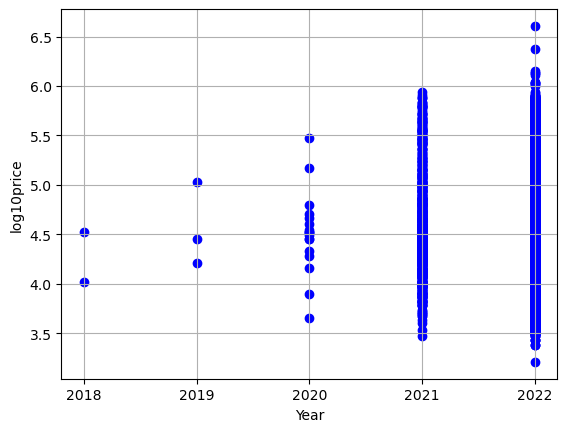

In [349]:
# # Plot log10price ~ year
plt.scatter(CARS['year'], CARS['log10price'], color='blue')
plt.xlabel('Year')
plt.ylabel('log10price')
plt.xticks(ticks=CARS['year'].unique())  # Use unique year values as ticks
plt.grid()
plt.show()

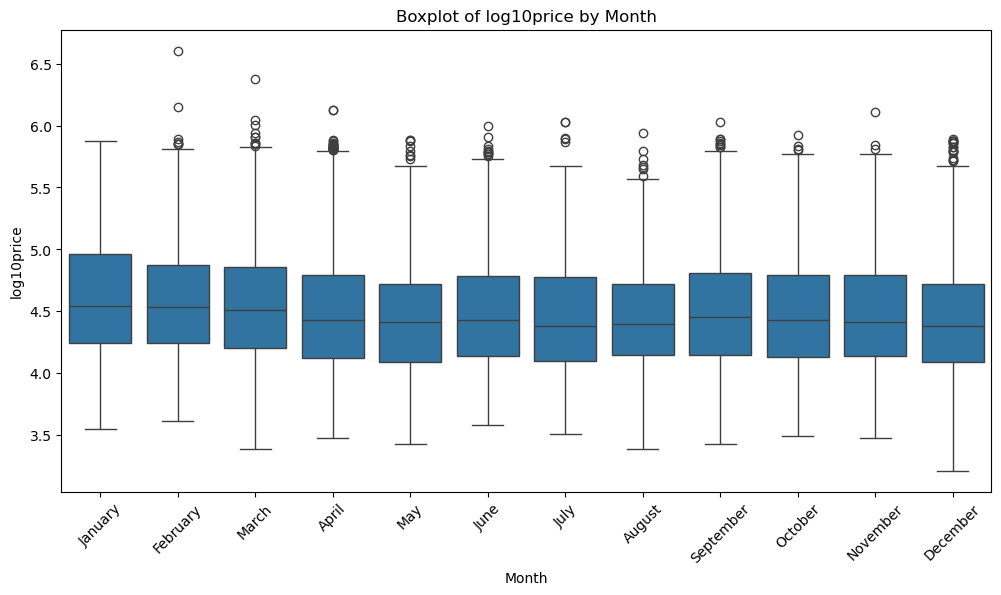

In [371]:
# # Plot log10price ~ year
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='log10price', data=CARS, order=pd.date_range('2023-01-01', '2023-12-31', freq='ME').strftime('%B').tolist())
plt.xlabel('Month')
plt.ylabel('log10price')
plt.title('Boxplot of log10price by Month')
plt.xticks(rotation=45)  
plt.show()

Our data now has no missing values, a reasonable (though large) number of levels for each categorical predictor, 
and symmetric-ish predictors (x) and response (y), so we're ready to start the model building process.

In [376]:
CARS.dropna().shape[0] / CARS.shape[0]

1.0

In [392]:
# CARS.value_counts()
print(CARS.describe(include='all'))

                body_condition    mechanical_condition seller_type body_type  \
count                     9970                    9970        9970      9970   
unique                       4                       3           3        13   
top     Perfect inside and out  Perfect inside and out      Dealer       SUV   
freq                      9612                    9822        6762      4566   
mean                       NaN                     NaN         NaN       NaN   
min                        NaN                     NaN         NaN       NaN   
25%                        NaN                     NaN         NaN       NaN   
50%                        NaN                     NaN         NaN       NaN   
75%                        NaN                     NaN         NaN       NaN   
max                        NaN                     NaN         NaN       NaN   
std                        NaN                     NaN         NaN       NaN   

        no_of_cylinders       transmiss

In [452]:
# Specify target variable
target = 'log10price'
# Separate predictors and target
X = CARS.drop(columns=[target])
y = CARS[target]
X = CARS.drop(columns=[target])


In [454]:
# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

Step 1:  split into training and holdout.  I like to do this manually and use `set.seed` to ensure reproducibility. 
Essentially, I pick the row numbers at random to figure out which rows end up in the training set and which end up in the holdout sample.

In [456]:
# Train-test split
np.random.seed(542)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Step 2:  Using crossvalidation.  For most purposes, 5-fold crossvalidation (no repeats) is typically appropriate.

In [458]:
# Evaluate pipeline with 5-fold cross-validation
folds = cross_val_score(
    model_pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
)


In [462]:
# Convert scores to positive MSE
cv_mse = -folds

In [464]:
# Preprocessing for numerical data
numerical_transformer = StandardScaler()

# Preprocessing for categorical data
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

In [466]:
# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

In [468]:
# Create the pipeline with preprocessing and model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

In [470]:
# Fit the model
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['no_of_cylinders', 'log10kilometers', 'car_year1'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  Index(['body_condition', 'mechanical_condition', 'seller_type', 'body_type',
       'transmission_type', 'regional_specs', 'horsepower', 'fuel_type',
       'color', 'emirate', 'motors_trim', 'company', 'model', 'date_posted',
       'car_year2', 'month'],
      dtype='object'))])),
                ('model', LinearRegression())])

In [474]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.019580601918962562
